In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv("C:\\Users\\marreddyGowthamreddy\\Desktop\\Internjunction\\Tesla price prediction.csv")
print(df.head())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2016-08-16  45.098000  45.438000  44.681999  44.722000  44.722000  11335500
1  2016-08-17  44.866001  44.966000  44.560001  44.647999  44.647999   8935500
2  2016-08-18  44.764000  45.132000  44.458000  44.702000  44.702000   8572500
3  2016-08-19  44.708000  45.034000  44.506001  45.000000  45.000000   8297500
4  2016-08-22  44.834000  45.021999  44.535999  44.585999  44.585999  10327500


In [6]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)
df.dropna(inplace=True)
print("Missing values after cleaning:\n", df.isnull().sum())

Missing values in each column:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing values after cleaning:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    print("Date column after conversion:\n", df['Date'].head())

Date column after conversion:
 0   2016-08-16
1   2016-08-17
2   2016-08-18
3   2016-08-19
4   2016-08-22
Name: Date, dtype: datetime64[ns]


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_Normalized'] = scaler.fit_transform(df[['Close']])
print(df[['Date', 'Close', 'Close_Normalized']].head())

        Date      Close  Close_Normalized
0 2016-08-16  44.722000          0.010537
1 2016-08-17  44.647999          0.010450
2 2016-08-18  44.702000          0.010513
3 2016-08-19  45.000000          0.010865
4 2016-08-22  44.585999          0.010377


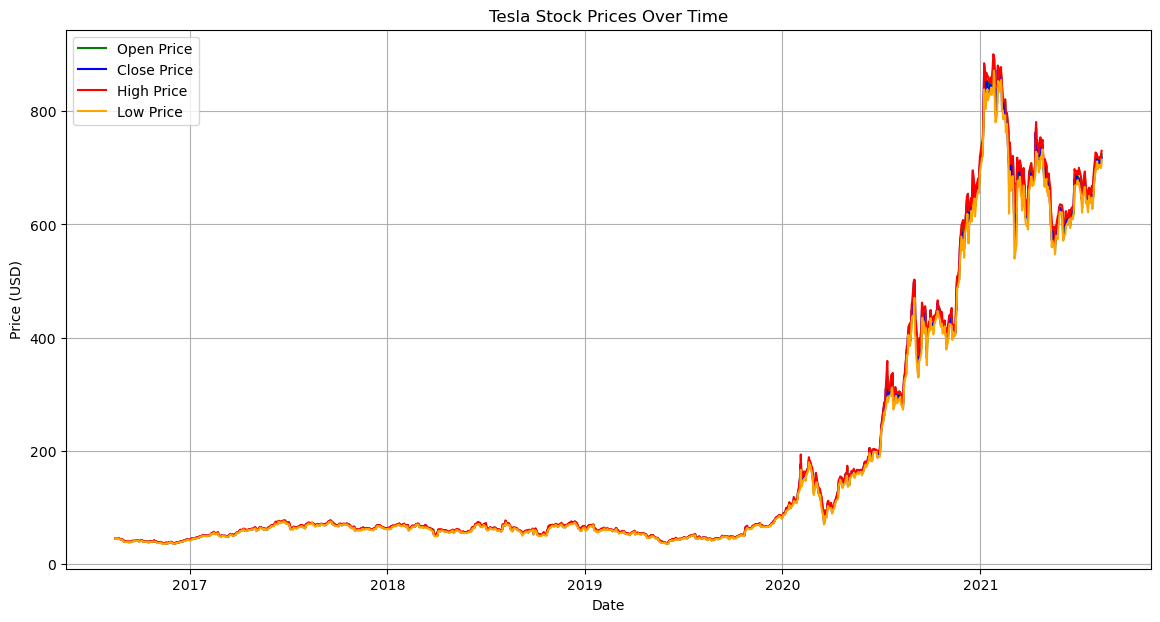

In [9]:
plt.figure(figsize=(14, 7))

plt.plot(df['Date'], df['Open'], label='Open Price', color='green')
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['High'], label='High Price', color='red')
plt.plot(df['Date'], df['Low'], label='Low Price', color='orange')

plt.title('Tesla Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

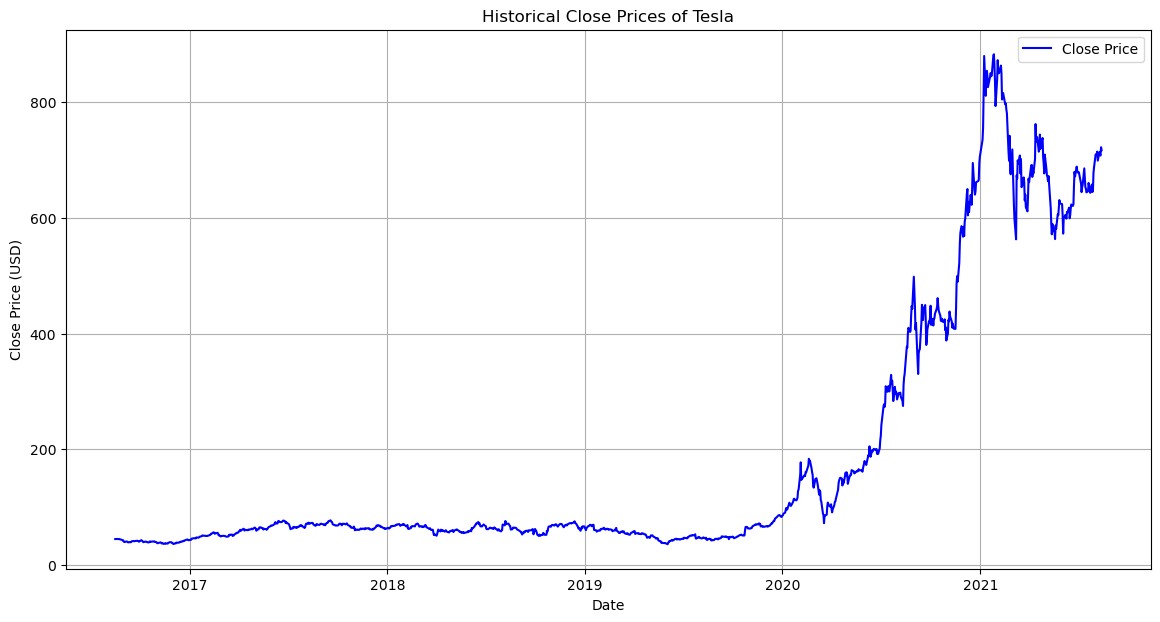

In [10]:
plt.figure(figsize=(14, 7))

plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')

plt.title('Historical Close Prices of Tesla')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
focus_year = 2020
df_focus = df[df['Date'].dt.year <= focus_year]
train_size = int(len(df_focus) * 0.8)
train_data = df_focus[:train_size]
test_data = df_focus[train_size:]

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (882, 8)
Testing data shape: (221, 8)


In [12]:
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60

train_close_prices = train_data['Close_Normalized'].values.reshape(-1, 1)
test_close_prices = test_data['Close_Normalized'].values.reshape(-1, 1)

X_train, y_train = create_sequences(train_close_prices, time_step)
X_test, y_test = create_sequences(test_close_prices, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (821, 60, 1)
y_train shape: (821,)
X_test shape: (160, 60, 1)
y_test shape: (160,)


In [13]:
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))  

model.add(GRU(units=50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

C:\Users\marreddyGowthamreddy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 5.5590e-04 - val_loss: 0.0273
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 8.0734e-05 - val_loss: 0.0035
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 2.7748e-05 - val_loss: 0.0013
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.1320e-05 - val_loss: 0.0012
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 2.5127e-05 - val_loss: 0.0011
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.3729e-05 - val_loss: 0.0013
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.6899e-05 - val_loss: 0.0011
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.0165e-05 - val_loss: 9.4802e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.9138e-05 - val_loss: 9.2561e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.4421e-05 - val_loss: 0.0016
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.7422e-05 - val_loss: 8.5890e-04
Epoch

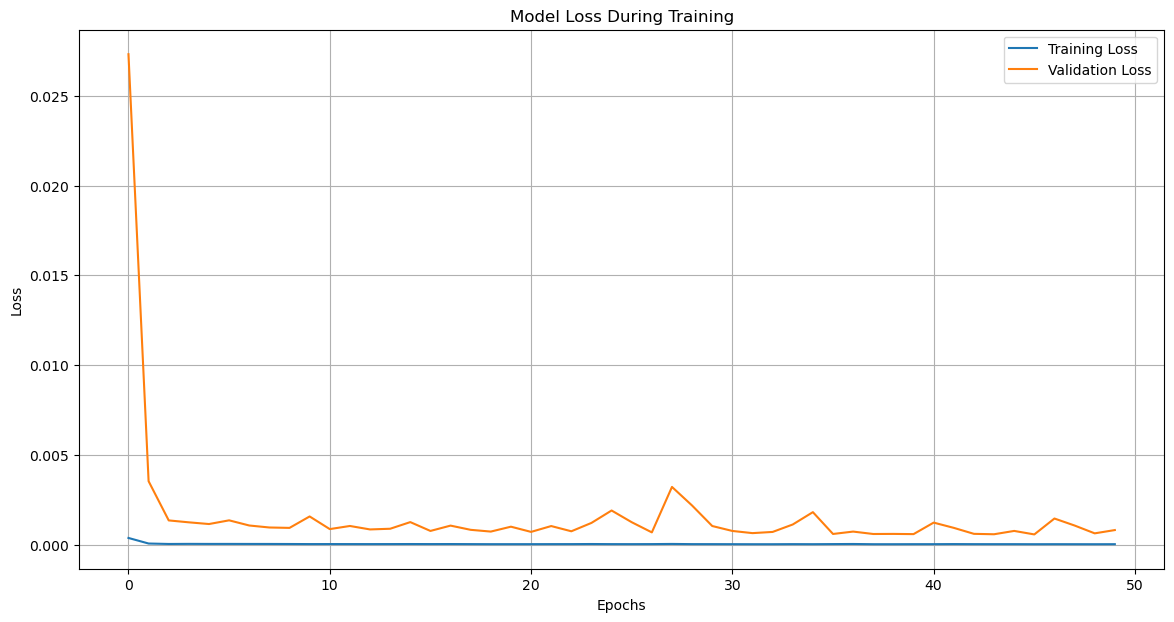

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

plt.figure(figsize=(14, 7))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predicted_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_scaled, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, predicted_prices)
r2 = r2_score(y_test_scaled, predicted_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mean Squared Error (MSE): 577.6359820333798
Root Mean Squared Error (RMSE): 24.03405879233426
Mean Absolute Error (MAE): 17.748596391589352
R² Score: 0.9719055386019295


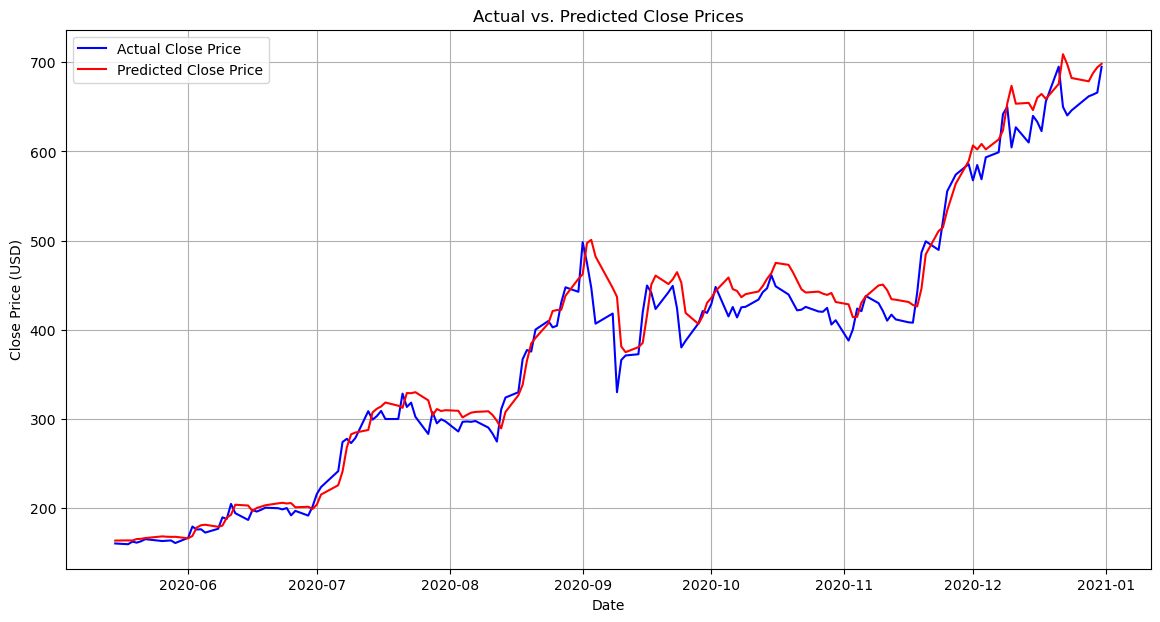

In [16]:
plt.figure(figsize=(14, 7))

plt.plot(df_focus['Date'][len(df_focus) - len(y_test_scaled):], y_test_scaled, label='Actual Close Price', color='blue')
plt.plot(df_focus['Date'][len(df_focus) - len(predicted_prices):], predicted_prices, label='Predicted Close Price', color='red')

plt.title('Actual vs. Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()